# Uncertainty Estimation in Tabular Regression
## Using MC Dropout, Deep Ensembles, and Temperature Scaling on Boston Housing Dataset

In [3]:
# Import necessary libraries: tensorflow for models, sklearn for dataset and metrics, pandas/numpy for data, matplotlib/seaborn for plots
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [4]:
# Load California Housing dataset from sklearn, convert to DataFrame, split into features (X) and target (y), then train-test split (80/20), standardize features
data = fetch_california_housing(as_frame=True)
X = data.data
y = data.target

# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split train into train/val (80/20 of train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Import the build_mlp function from models/simple_mlp.py
from models.simple_mlp import build_mlp

Epoch 1/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2189 - val_loss: 0.5653
Epoch 2/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5868 - val_loss: 0.4330
Epoch 3/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5006 - val_loss: 0.4043
Epoch 4/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4657 - val_loss: 0.3942
Epoch 5/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4451 - val_loss: 0.3752
Epoch 6/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4361 - val_loss: 0.3683
Epoch 7/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4154 - val_loss: 0.3672
Epoch 8/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4196 - val_loss: 0.3549
Epoch 9/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3978 - val_loss: 0.3547
Epoch 10/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3854 - val_loss: 0.3448
Epoch 11/100
331/331 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3821 - val_loss: 0.3460
Epoch 12/100
331/331 ━━━━━━━━━━━━━━━━━━━━

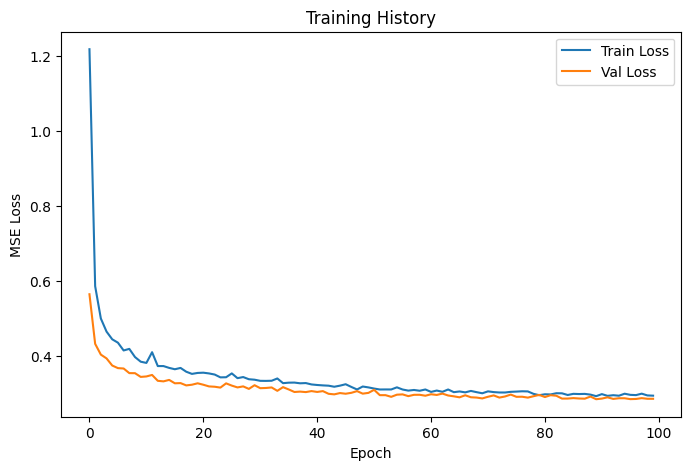

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 713us/step
Test MSE: 0.2900, RMSE: 0.5386, R2: 0.7787


In [6]:
# Build the MLP model with input shape from X_train
mlp_model = build_mlp(X_train_scaled.shape[1])

# Train on X_train_scaled, y_train for 100 epochs, batch_size=32, validation_split=0.2
history = mlp_model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot training history (loss and val_loss)
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.show()

# Evaluate on test set
predictions = mlp_model.predict(X_test_scaled).flatten()
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print(f"Test MSE: {mse:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")

In [7]:
# Import mc_dropout_predict from methods/mc_dropout.py
from methods.mc_dropout import mc_dropout_predict

# Get MC Dropout predictions on X_test
means_mc, stds_mc = mc_dropout_predict(mlp_model, X_test_scaled, n_samples=30)

# Compute metrics: MSE between means and y_test, average interval width (1.96 * stds)
mse_mc = mean_squared_error(y_test, means_mc)
avg_interval_width_mc = 2 * 1.96 * np.mean(stds_mc)
print(f"MC Dropout Test MSE: {mse_mc:.4f}")
print(f"MC Dropout Avg. 95% Interval Width: {avg_interval_width_mc:.4f}")

MC Dropout Test MSE: 0.2915
MC Dropout Avg. 95% Interval Width: 0.5795


In [8]:
# Import train_ensemble and ensemble_predict from methods/deep_ensemble.py
from methods.deep_ensemble import train_ensemble, ensemble_predict
import time

# Train ensemble on X_train_scaled, y_train
start_time = time.time()
ensemble_models = train_ensemble(X_train_scaled, y_train, k=5, epochs=100)
train_time = time.time() - start_time
print(f"Ensemble training time: {train_time:.2f} seconds")

# Get ensemble means and stds on X_test
means_ens, stds_ens = ensemble_predict(ensemble_models, X_test_scaled)

# Compute metrics: MSE between means and y_test, average interval width (1.96 * stds)
mse_ens = mean_squared_error(y_test, means_ens)
avg_interval_width_ens = 2 * 1.96 * np.mean(stds_ens)
print(f"Ensemble Test MSE: {mse_ens:.4f}")
print(f"Ensemble Avg. 95% Interval Width: {avg_interval_width_ens:.4f}")

Ensemble training time: 299.89 seconds
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Ensemble Test MSE: 0.2823
Ensemble Avg. 95% Interval Width: 0.4095
Ensemble Test MSE: 0.2823
Ensemble Avg. 95% Interval Width: 0.4095
